## 理解 PyTorch 计算图、Autograd 机制和实现线性拟合

### 参考
* [机器学习经典算法之-----最小二乘法](http://www.cnblogs.com/armysheng/p/3422923.html)
* [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html)
* [计算图（computational graph）角度看BP（back propagation）算法](https://blog.csdn.net/u013527419/article/details/70184690)
* [PyTorch学习总结(七)——自动求导机制](https://blog.csdn.net/manong_wxd/article/details/78734358)
* [自动求导机制](https://pytorch-cn.readthedocs.io/zh/latest/notes/autograd/)

### 计算图

启发于 cs231n 的 [Deep Learning Hardware and Software](http://cs231n.stanford.edu/syllabus.html)，课程在里面介绍了 pytorch 的自动求导机制和动态计算图。

我们都知道梯度下降和反向传播需要求解每一层的梯度，以更新权重。[Caffe Layers](https://github.com/BVLC/caffe/tree/master/src/caffe/layers) 采用的机制是对每一层都定义一个 `backward` 和 `forward` 操作，然后在这两个函数中前馈、计算梯度等。

Computational Graph 指的是一系列的操作，包括输出的数据。

例如课程中的例子，利用 PyTorch 自动求导机制求 x, y 的梯度和 numpy 对比，中间则是计算图，实现的是 $c=\sum{(x*y+z)}$。

![](https://tuchuang-1252747889.cosgz.myqcloud.com/2018-11-25-123659.png)

TensorFlow 的数据流图的例子，数据经过节点被处理，然后输出，就像水一样流动:

![](https://tuchuang-1252747889.cosgz.myqcloud.com/2018-11-25-tensors_flowing.jpg)

**Pytorch 是动态图，每一次训练，都会销毁图并重新创建，这样做花销很大，但是更加灵活。**而 Tensorflow 是静态图，一旦定义训练时就不能修改。Pytorch 合并 caffe2 发布 1.0 版本之后引入静态图，而 Tensorflow 已经发布 [Eager Execution](https://www.tensorflow.org/guide/eager) 引入动态图。但相对来说还是 Pytorch 更加灵活。

### Autograd mechanics

首先要知道，Pytorch 的数据和参数（权重、偏置等）都是以 Tensor 存储的，Pytorch 的 Tensor 相当于 caffe 的 Blob，Tensorflow 的 Tensor。Pytorch 已经定义了 Tensor 的很多操作，可以在 GPU 上运算加速。

Pytorch 会自动跟踪计算图的操作，在计算图执行完成后，调用 `backward` 计算梯度。很久以前数据需要使用 `Variable` 封装，像这样的:

![](https://tuchuang-1252747889.cosgz.myqcloud.com/2018-11-25-68960-7084a4be66464e40.png)

data 存储数据，grad 存储梯度，creator 指向创建者。

现在不用这么麻烦了，直接合并 Tensor 和 Variable，只需要 `requires_grad=True` 表明需要计算梯度。

需要注意: **只有当任意一个输入的 Tensor 不需要计算梯度时，输出才不需要计算梯度；如果有一个需要计算，输出就需要。**

In [2]:
import torch
x = torch.randn(5, 5)
y = torch.randn(5, 5)
z = x + y
z.requires_grad

False

In [3]:
x = torch.randn(5, 5, requires_grad=True)
y = torch.randn(5, 5)
z = x + y
z.requires_grad

True

实现自定义的 Tensor 自动求导需要实现 `forward` 和 `backward`，例如 cs231n 的例子:

![](https://tuchuang-1252747889.cosgz.myqcloud.com/2018-11-25-%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-11-25%20%E4%B8%8B%E5%8D%889.10.56.png)

`backward` 之后更新完参数需要清除梯度，`torch.no_grad` 是指在此的计算不创建图的节点。

### 实现线性拟合

线性拟合是初中的知识，很简单，就是用一条直线拟合一些点，并使得点到直线的距离之和最短。常用最小二乘法求解，这里使用梯度下降（虽然线性拟合有公式直接求解）。点到直线的距离公式:

$$
d = \left| \frac { A x _ { 0 } + B y _ { 0 } + C } { \sqrt { A ^ { 2 } + B ^ { 2 } } } \right|
$$

接下来我就生成一些点，并假设直线为 $y=ax+b$，那么点到直线的距离为:

$$
d = \left| \frac { a x _ { 0 } - y _ { 0 } + b } { \sqrt { a ^ { 2 } + 1 } } \right|
$$

因此定义损失函数为:

$$
L = \frac{1}{2N}\sum_i \frac{(a x _ { i } - y _ { i } + b)^2}{a^2+1}
$$

显然可以对 $L$ 直接求导，但是这个公式直接对 $a$ 和 $b$ 求偏导太麻烦，最后的结果很复杂，可能这就是距离公式常用 MSE 和 MAE 的原因。但是我可以用 Pytorch 的计算图自动求导解决。

生成一些随机点:

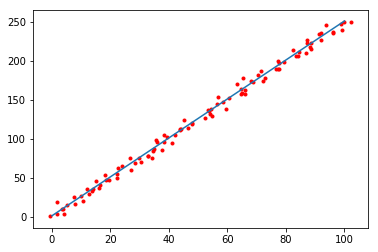

In [72]:
import numpy as np
import random
import matplotlib.pyplot as plt
# 在0-2*pi的区间上生成100个点作为输入数据
X = np.linspace(0, 100, 100,endpoint=True)
a, b = 2.5, 1.0
Y = a*X+b

# 对输入数据加入gauss噪声
# 定义gauss噪声的均值和方差
mu = 0
sigma = 2
Nx, Ny = X.copy(), Y.copy()
for i in range(X.shape[0]):
    Nx[i] += random.gauss(mu,sigma)
    Ny[i] += random.gauss(mu,sigma)

# 画出这些点
plt.plot(X, Y)
plt.scatter(Nx, Ny, marker='.', color='r')
plt.show()

接下来就是一系列计算然后更新 $a$ 和 $b$ 了。

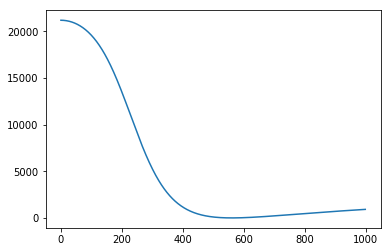

In [73]:
X = torch.from_numpy(Nx)
Y = torch.from_numpy(Ny)
X = X.float()
Y = Y.float()
lr = 1e-9
iA, iB = torch.Tensor([0]), torch.Tensor([0])
# 需要计算梯度
iA.requires_grad = True
iB.requires_grad = True

# 记录最好的结果
best_loss = float("inf")
best_a = 0.0
best_b = 0.0
loss_list = []
max_epochs = 1000

# 梯度下降
for _ in range(max_epochs):
    # 计算 loss
    loss = torch.mean((iA*X-Y+iB)**2/(iA**2+1))
    # 反向传播
    loss.backward()
    # 更新参数
    with torch.no_grad():
        iA -= lr*iA.grad
        iB -= lr*iB.grad
        cur_loss = loss.item()
        if cur_loss<best_loss:
            best_a = iA.item()
            best_b = iB.item()
            best_loss = cur_loss
        loss_list.append(cur_loss)

# loss 曲线
plt.plot(list(range(max_epochs)), loss_list)
plt.show()

In [76]:
best_a, best_b, best_loss

(2.511101245880127, 0.02796928584575653, 4.386769771575928)

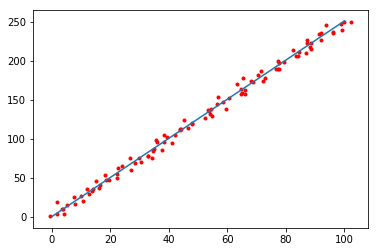

In [75]:
nX = np.linspace(0, 100, 100,endpoint=True)
plt.plot(nX, best_a*nX+best_b)
plt.scatter(Nx, Ny, marker='.', color='r')
plt.show()

最后可以看到拟合效果已经很好了。调节 learning rate 可以获得更好的效果，loss 曲线最后又增大是因为可能在最小值点，loss 震荡，无法到达最小值点。这点可以参考我的梯度下降的理解博客。

当 learning rate 较大时，拟合的效果没有这么好。**总结就是梯度下降法应用 learning rate deacy 的非常重要。**